# Job Clusters in Los Angeles County  

Hi, it's Audrey. Shinah and I were thinking how we can apply spatial statistics to our research question, and I thought the best applicaiton would be on LA job data. On the Map provides job data in point form, and previously we had been unable to calculate job density through spatial join. 

In this notebook, I generate what point pattern plots I could using seaborn. I ran into 3 issues: 
1. I couldn't read in Census block group shapes (or Census tract shapes for that matter) without crashing my notebook;  
2. The jointplots ran into a NaN error message, but when I tried to drop the null values the gdf wouldn't plot; and
3. I couldn't get the seaborn jointplots to draw a basemap, perhaps because of #2. 

Theoretically I could spatial autocorrelation to identify job clusters in LA County, joining job count point data to census block group shapefile. But because of the above issues I couldn't get past the spatial join. 

In [1]:
# to read and wrangle data
import pandas as pd

# to import data from LA Data portal
from sodapy import Socrata

# to create spatial data
import geopandas as gpd

# for basemaps
import contextily as ctx

# For spatial statistics
import esda
from esda.moran import Moran, Moran_Local

import splot
from splot.esda import moran_scatterplot, plot_moran, lisa_cluster,plot_moran_simulation

import libpysal as lps

# Graphics
import matplotlib.pyplot as plt
import plotly.express as px

/opt/conda/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.1-CAPI-1.13.3) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
LA_jobs = gpd.read_file('AYJ-GroupData/points_2018.shp')
LA_jobs.head()

,id,c000,ca01,ca02,ca03,ce01,ce02,ce03,cns01,cns02,...,cr07,ct01,ct02,cd01,cd02,cd03,cd04,cg01,cg02,geometry
0,060374600003006,12.0,3.0,3.0,6.0,0.0,8.0,4.0,0.0,0.0,...,0.0,10.0,2.0,0.0,4.0,3.0,2.0,7.0,5.0,POINT (-2001134.000 -138945.141)
1,060374300025013,3.0,0.0,3.0,0.0,2.0,1.0,0.0,0.0,0.0,...,0.0,2.0,1.0,1.0,1.0,1.0,0.0,1.0,2.0,POINT (-1991025.125 -145032.016)
2,060374300025015,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,POINT (-1991167.125 -145140.297)
3,060374300025014,21.0,10.0,8.0,3.0,9.0,12.0,0.0,0.0,0.0,...,0.0,10.0,11.0,1.0,2.0,2.0,6.0,12.0,9.0,POINT (-1991184.625 -145096.594)
4,060374300025021,4.0,0.0,3.0,1.0,4.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,0.0,2.0,2.0,0.0,3.0,1.0,POINT (-1991041.750 -145197.812)


Keep just the total job count, and rename columns: 

In [3]:
keep_job_columns = ['id',
 'c000',
 'geometry']

In [4]:
LA_jobs = LA_jobs[keep_job_columns]

In [5]:
LA_jobs.columns = ['GEOID', 'Job Count', 'geometry']

In [6]:
# drop rows with null values
#LA_jobs = LA_jobs['Job Count'].dropna()

In [7]:
LA_jobs.sort_values(by=['GEOID'])

,GEOID,Job Count,geometry
49513,060371011101000,5.0,POINT (-2017971.375 -124936.320)
49512,060371011101001,2.0,POINT (-2018033.375 -124815.984)
49514,060371011101002,4.0,POINT (-2018116.000 -124790.492)
49515,060371011101003,3.0,POINT (-2018189.625 -124771.758)
49511,060371011101004,7.0,POINT (-2018321.000 -124834.086)
...,...,...,...
51202,060379800331097,214.0,POINT (-2024182.000 -182011.906)
51253,060379800331098,499.0,POINT (-2022703.000 -182497.125)
50696,060379800331108,110.0,POINT (-2023497.875 -181708.656)
50004,060379800331111,105.0,POINT (-2023436.750 -183717.828)


##### Heat Map 

The raw job count data, with one dot at each GEOID: 

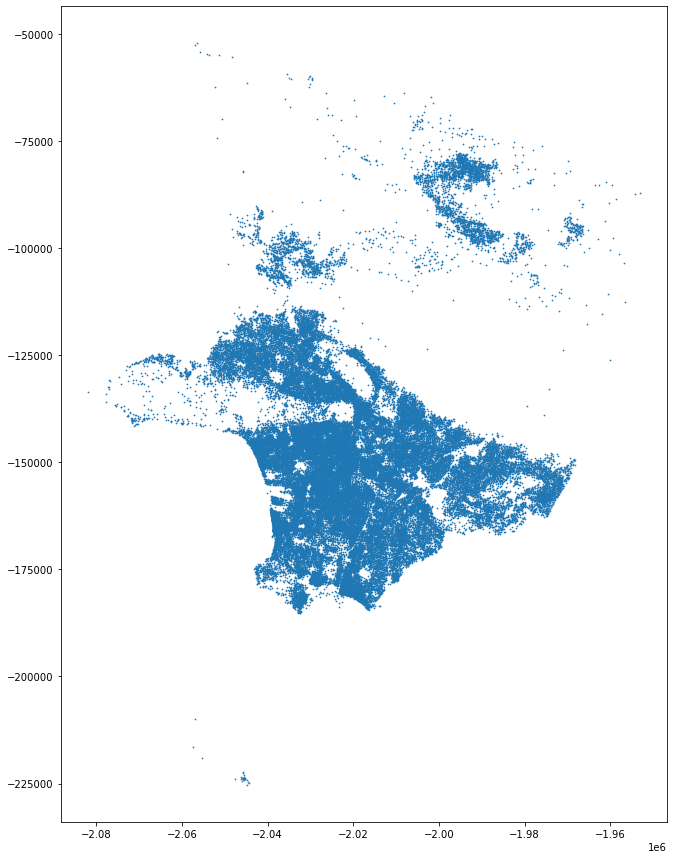

In [8]:
LA_jobs.plot(figsize = (15,15), 
             markersize = 0.5)

In [9]:
LA_jobs.crs

<Projected CRS: ESRI:102003>
Name: USA_Contiguous_Albers_Equal_Area_Conic
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Albers Equal Area
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

## Spatial Autocorrelation

Steps for spatial autocorrelation:
1. Spatial join count gdf to shapefile (Census block groups in this case)
2. Normalize to per 100 people who live in the Census block group 
3. Map a slice of the data (top 5 geographies) 
4. Chloropleth map of jobs ... I guess we have to weight it according to the rid
5. Spatial weights:  define spatial weights
6. Spatial lag: for each geography, the average of all neighbors' spatial weight 
7. difference btwn job count and lag 
8. spatial lag map
9. Moran's Plot: quantifying degree of spatial correlations - test for global autocorrelation for continuous attribute (job counts) 
10. Moral Local scatterplot
11. spatial autocorrelation map 

In [24]:
LA_blockgroup = gpd.read_file('AYJ-GroupData/acs2019_5yr_B01003_15000US060372732001.shp)

SyntaxError: EOL while scanning string literal (<ipython-input-24-4a33714de642>, line 1)

In [26]:
LA_blockgroup = gpd.read_file('AYJ-GroupData/Census_Block_Groups_in_LA_County.shp)

SyntaxError: EOL while scanning string literal (<ipython-input-26-b42076a96ed4>, line 1)

## Point Pattern Analysis

data visualization libraries 
1. matplotlib --> static images
2. plotly --> interactive javascript
3. seaborn --> statistical analysis

Source: https://seaborn.pydata.org/tutorial/relational.html

##### Seaborn plots

In [10]:
# new for data viz
import seaborn as sns

# to explore point patterns
from pointpats import centrography
from matplotlib.patches import Ellipse
import numpy

In [11]:
# seaborn needs an x and y column so let's extract it from the geometry field
LA_jobs['x'] = LA_jobs.geometry.x
LA_jobs['y'] = LA_jobs.geometry.y

Plotting the job count data, marking more concentrated points with darker, larger circles: 

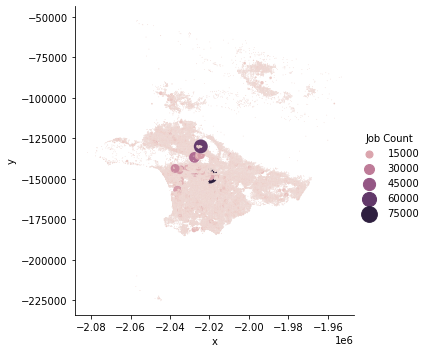

In [12]:
sns.relplot(x="x", y="y", size="Job Count", sizes=(0.5, 250), hue = "Job Count", data=LA_jobs);

Because this is just job count data, there aren't meaningful multiple plots that can be created. I want to see where the highest job count points are, so I'll draw a jointmap with a basemap: 

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


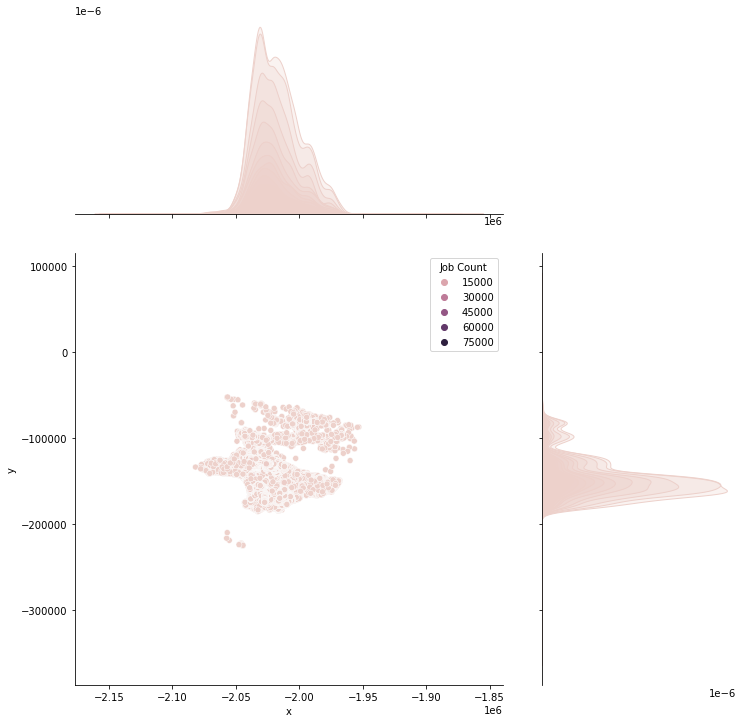

In [13]:
sns.jointplot(x="x", y="y", hue="Job Count", height=10, ratio=2, data=LA_jobs)

Is the map too small to show the higher job counts? 

/opt/conda/lib/python3.8/site-packages/seaborn/distributions.py:1181: UserWarning: The following kwargs were not used by contour: 's'
  cset = contour_func(
/opt/conda/lib/python3.8/site-packages/contextily/tile.py:579: RuntimeWarning: invalid value encountered in subtract
  lon_length = np.subtract(*lon_range)
/opt/conda/lib/python3.8/site-packages/contextily/tile.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  zoom_lat = np.ceil(np.log2(360 * 2.0 / lat_length))


ValueError: cannot convert float NaN to integer

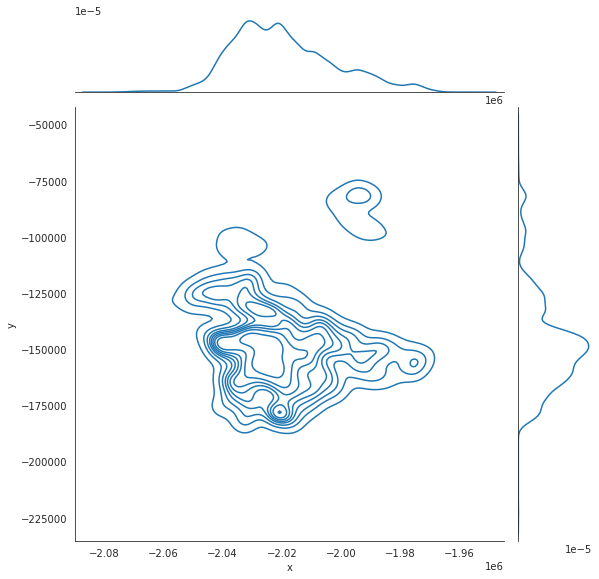

In [14]:
# add a basemap to jointplots
# scatterplot with edges
sns.set_style('white')
g = sns.jointplot(data = LA_jobs, # put the map into a variable 
                  x='x', 
                  y='y',
                  s=10,
                  dropna = True,
                  kind = 'kde',
                  height=8 # make the map bigger
                 )

# add basemap
ctx.add_basemap(g.ax_joint, #argument from cborn for basemaps 
                crs='epsg:4326')
 

What are these errors? I dropped the null values... And why isn't the basemap plotting? 

Seems tilemapbase is an option... (Source: https://rosenfelder.ai/create-maps-with-python/)

Tried using tilemapbase, but couldn't import library? (Source: https://github.com/MatthewDaws/TileMapBase - Uses OpenStreetMap tiles, or other tile servers, to produce "basemaps" for use with matplotlib)


In [23]:
# pip install https://github.com/MatthewDaws/TileMapBase/zipball/master

 ##### Centrography 
 
 * central tendency: mean center and median center
 * dispersion
 * orientation 
 latter two use standard deviational elipse 
 
 global center of job count dataset -- i.e., what is the statistical central locations of job distribution? 

In [16]:
# compute the mean and median centers
mean_center = centrography.mean_center(LA_jobs[['x','y']])
med_center = centrography.euclidean_median(LA_jobs[['x','y']])

/opt/conda/lib/python3.8/site-packages/contextily/tile.py:579: RuntimeWarning: invalid value encountered in subtract
  lon_length = np.subtract(*lon_range)
/opt/conda/lib/python3.8/site-packages/contextily/tile.py:584: RuntimeWarning: divide by zero encountered in double_scalars
  zoom_lat = np.ceil(np.log2(360 * 2.0 / lat_length))


ValueError: cannot convert float NaN to integer

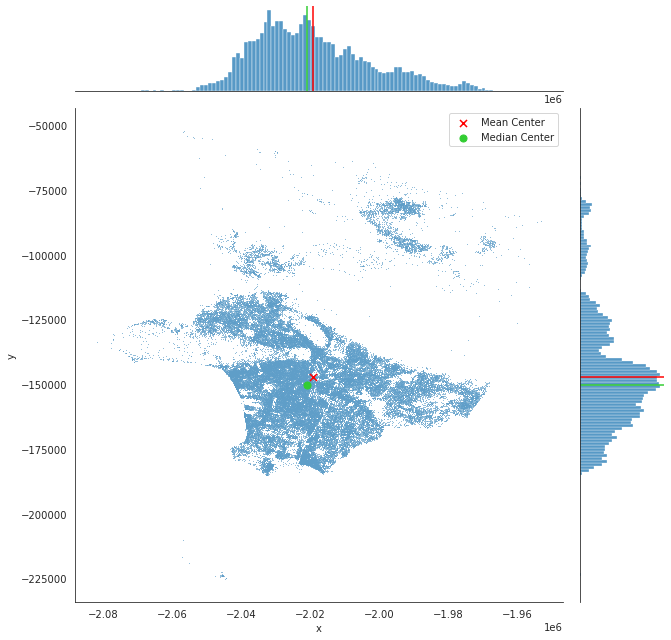

In [17]:
# Generate scatter plot
g = sns.jointplot(
    x='x', y='y', data=LA_jobs, s=0.75, height=9
)

# Add mean point and marginal lines
g.ax_joint.scatter(
    *mean_center, color='red', marker='x', s=50, label='Mean Center'
)
g.ax_marg_x.axvline(mean_center[0], color='red')
g.ax_marg_y.axhline(mean_center[1], color='red')

# Add median point and marginal lines
g.ax_joint.scatter(
    *med_center, color='limegreen', marker='o', s=50, label='Median Center'
)
g.ax_marg_x.axvline(med_center[0], color='limegreen')
g.ax_marg_y.axhline(med_center[1], color='limegreen')

# Legend
g.ax_joint.legend()

# Add basemap
ctx.add_basemap(
    g.ax_joint, 
    crs='epsg:4326',
    source=ctx.providers.CartoDB.Positron
)

# Clean axes
g.ax_joint.set_axis_off()

# Display
plt.show()


##### Dispersion and Orientation 

directional distribution of job count data in Los Angeles 

standard deviational ellipse: st. dev. are calculated for the coordinates of mean center. 

In [20]:
major, minor, rotation = centrography.ellipse(LA_jobs[['x','y']])

ValueError: cannot convert float NaN to integer

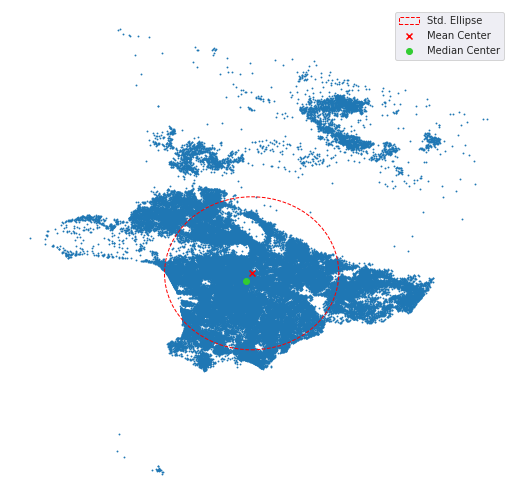

In [21]:
# set the style without grid lines
sns.set_style('dark')

# Set up figure and axis
f, ax = plt.subplots(1, figsize=(9, 9))

# Plot points
ax.scatter(LA_jobs['x'], LA_jobs['y'], s=0.75)
ax.scatter(*mean_center, color='red', marker='x', label='Mean Center')
ax.scatter(*med_center, color='limegreen', marker='o', label='Median Center')

# Construct the standard ellipse using matplotlib
ellipse = Ellipse(xy=mean_center, # center the ellipse on our mean center
                  width=major*2, # centrography.ellipse only gives half the axis
                  height=minor*2, 
                  angle = numpy.rad2deg(rotation), # Angles for this are in degrees, not radians
                  facecolor='none', 
                  edgecolor='red', 
                  linestyle='--',
                  label='Std. Ellipse')

ax.add_patch(ellipse)

ax.legend()

ax.axis('off')

# add a basemap
ctx.add_basemap(ax,
                crs='epsg:4326',
                source=ctx.providers.CartoDB.Positron)

# Display
plt.show()